## **Imports**

In [31]:
import os
import joblib
import pandas as pd
import seaborn as sns

from scipy.stats import uniform

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

## **Paths & Global Variables**

In [30]:
ROOT_PATH = r"C:\Users\mario\OneDrive\Documents\Work\Side Hustles\Kaggle\titanic"
TARGET_VAR = "survived"

import sys

sys.path.append(ROOT_PATH)

from titanic.config import PROCESSED_DATA_DIR, MODELS_DIR

## **Reading Data**

In [ ]:
os.chdir(PROCESSED_DATA_DIR)

X_train = pd.read_parquet("X_train.parquet")
y_train = pd.read_parquet("y_train.parquet")

X_test = pd.read_parquet("X_val.parquet")
y_test = pd.read_parquet("y_val.parquet")

X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

# **Linear Discriminant Analysis**

In [4]:
# Create LDA model
lda = LinearDiscriminantAnalysis(n_components=1)

In [5]:
# Fit the data and create a subspace X_new
X_new = lda.fit_transform(X_train, y_train.values.ravel())

<Axes: >

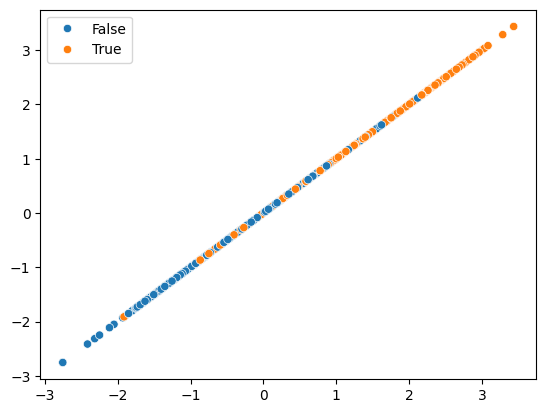

In [6]:
sns.scatterplot(x=X_new[:, 0], y=X_new[:, 0], hue=y_train.values.ravel())

# **Logistic Regression**

## **Model Fitting**

In [7]:
log_reg = LogisticRegression(class_weight="balanced", solver="liblinear")
log_reg.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

## **Hyperparameter Tuning**

In [9]:
distributions = {"penalty": ["l1", "l2"], "C": uniform(loc=0, scale=100)}

In [12]:
clf = RandomizedSearchCV(log_reg, distributions, n_iter=30, cv=10, scoring="roc_auc")
clf.get_params()

{'cv': 10,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__class_weight': 'balanced',
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'deprecated',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'liblinear',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(class_weight='balanced', solver='liblinear'),
 'n_iter': 30,
 'n_jobs': None,
 'param_distributions': {'penalty': ['l1', 'l2'],
  'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x17b09f3f770>},
 'pre_dispatch': '2*n_jobs',
 'random_state': None,
 'refit': True,
 'return_train_score': False,
 'scoring': 'roc_auc',
 'verbose': 0}

In [13]:
clf.fit(X_new, y_train.values.ravel())
best_model = clf.best_estimator_
print(best_model)
print(clf.best_params_)

LogisticRegression(C=np.float64(65.9903474983826), class_weight='balanced',
                   penalty='l1', solver='liblinear')
{'C': np.float64(65.9903474983826), 'penalty': 'l1'}


## **Model Testing**

In [ ]:
# Transform test data using the same LDA transformation
X_test_lda = lda.transform(X_test)

In [14]:
THRESHOLD = 0.5

In [16]:
y_predicted_probs = best_model.predict_proba(X_test_lda)[:, 1]
if THRESHOLD == 0.5:
    y_predicted = best_model.predict(X_test_lda)
else:
    y_predicted = (y_predicted_probs > THRESHOLD) * 1.0

In [20]:
y_predicted_df = pd.DataFrame(y_predicted, columns=["predicted"], index=X_test.index)
y_predicted_probs_df = pd.DataFrame(
    y_predicted_probs, columns=["probability"], index=X_test.index
)
y_predicted_df = pd.concat([y_predicted_df, y_predicted_probs_df], axis=1)
y_predicted_df.head()

,predicted,probability
passenger_id,,
161,False,0.088593
127,False,0.206021
429,False,0.206021
423,False,0.115686
566,False,0.113612


## **Evaluation Metrics**

In [22]:
best_score = clf.best_score_
test_score = clf.score(X_test_lda, y_test)
print(best_score)
print(test_score)

0.870743390438158
0.8393048128342246


In [24]:
test_conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_predicted),
    index=["actual no", "actual yes"],
    columns=["predicted no", "predicted yes"],
)

test_conf_matrix

,predicted no,predicted yes
actual no,88,22
actual yes,16,52


In [25]:
metrics_dict = {
    "Accuracy": accuracy_score(y_test, y_predicted),
    "Precision": precision_score(y_test, y_predicted),
    "Recall": recall_score(y_test, y_predicted),
    "F1 Score": f1_score(y_test, y_predicted),
}

metrics_df = pd.DataFrame(
    metrics_dict.values(), index=metrics_dict.keys(), columns=["Value"]
)

roc_auc = roc_auc_score(y_test, y_predicted_probs)
gini = 2 * roc_auc - 1

metrics_df.loc["ROC AUC"] = roc_auc
metrics_df.loc["Gini"] = gini

metrics_df

,Value
Accuracy,0.786517
Precision,0.702703
Recall,0.764706
F1 Score,0.732394
ROC AUC,0.839305
Gini,0.678610


## **Feature Importance**

In [29]:
best_model.n_features_in_

1

## **Model & Prediction Export**

In [35]:
os.chdir(MODELS_DIR)
# Save model
joblib.dump(best_model, "lda-model.joblib")
joblib.dump(lda, "lda-transformer.joblib")
# Save predictions
y_predicted_df.to_parquet("lda-y_predicted.parquet")